# Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

#  Load Dataset

In [4]:
path = 'dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [5]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path     Labels
0  dataset\sandstorm\3257.jpg  sandstorm
1    dataset\rainbow\0713.jpg    rainbow
2       dataset\rime\5479.jpg       rime
3        dataset\dew\2244.jpg        dew
4      dataset\glaze\6398.jpg      glaze

#  EDA & Visualization

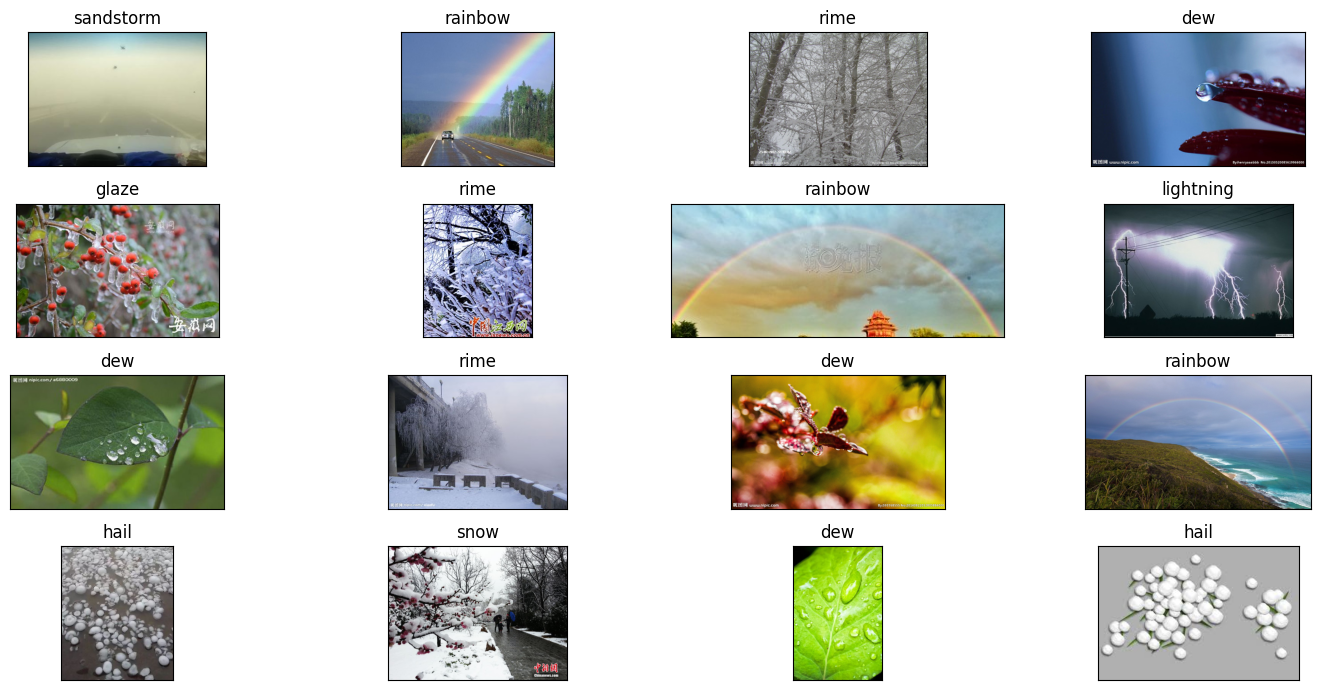

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

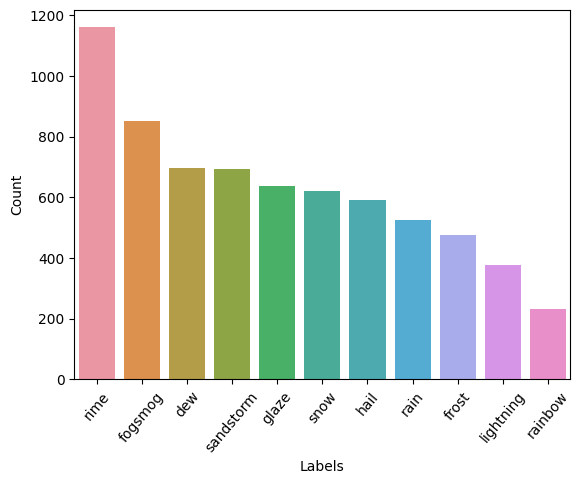

In [7]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

#  Train & Test Split

In [8]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

#  Functions

In [9]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [10]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [12]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [13]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

#  Training models

#  EfficientNetB7

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.


2021-11-18 16:40:08.141923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:40:08.258931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:40:08.260040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:40:08.261870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

258088960/258076736 [==============================] - 2s 0us/step


2021-11-18 16:40:21.626834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-18 16:40:44.940593: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


              precision    recall  f1-score   support

         dew       0.87      0.82      0.85       146
     fogsmog       0.62      0.94      0.75       173
       frost       0.62      0.57      0.59        93
       glaze       0.65      0.73      0.69       147
        hail       0.80      0.91      0.85       102
   lightning       0.95      0.77      0.85        73
        rain       0.84      0.64      0.72       107
     rainbow       0.98      0.93      0.95        44
        rime       0.88      0.81      0.84       245
   sandstorm       0.78      0.72      0.75       126
        snow       0.78      0.56      0.65       120

    accuracy                           0.77      1376
   macro avg       0.80      0.76      0.77      1376
weighted avg       0.78      0.77      0.77      1376



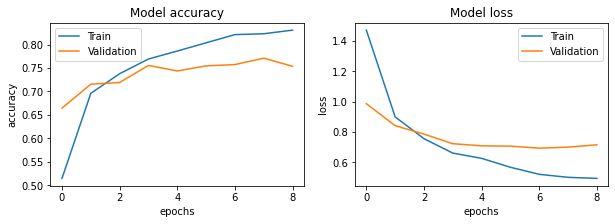

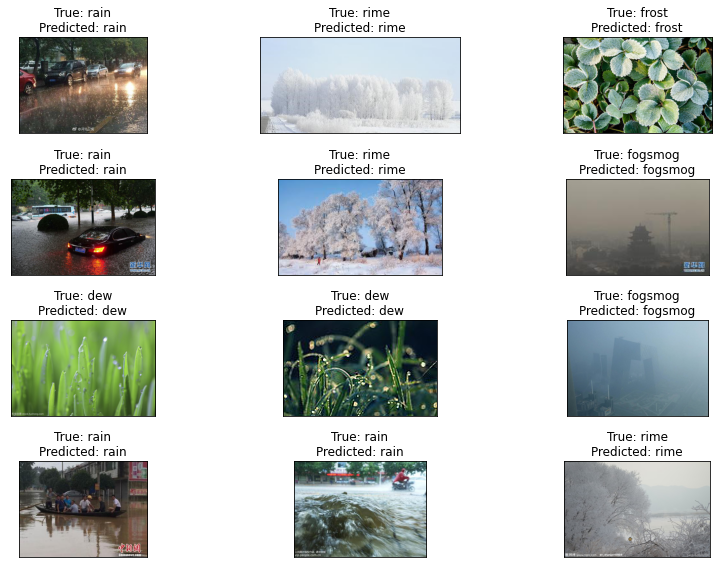

    Test Loss: 0.69611
Test Accuracy: 76.82%


In [11]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

#  ResNet

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
94781440/94765736 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.86      0.90      0.88       146
     fogsmog       0.90      0.90      0.90       173
       frost       0.66      0.69      0.67        93
       glaze       0.77      0.73      0.75       147
        hail       0.79      0.93      0.86       102
   lightning       0.93      0.97      0.95        73
        rain       0.99      0.64      0.78       107
     rainbow       0.97      0.89      0.93        44
        rime       0.85      0.84      0.84       245
   sandstorm       0.87      0.92      0.90       126
        snow       0.68      0.75      0.71       120

    accuracy                           0.83      1376
   macro avg       0.84      0.83      0.83  

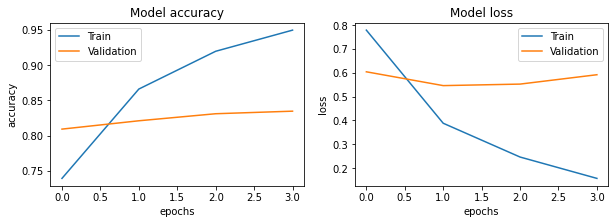

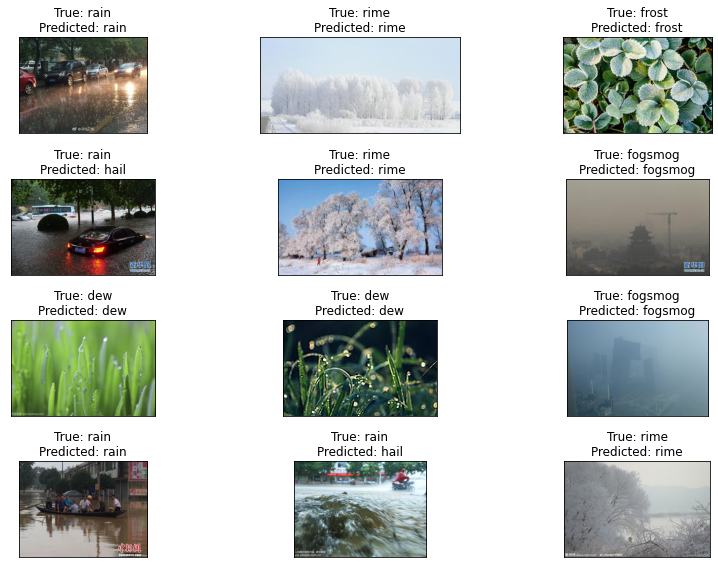

    Test Loss: 0.60345
Test Accuracy: 83.07%


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

#  MobileNet

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
17235968/17225924 [==============================] - 0s 0us/step
              precision    recall  f1-score   support

         dew       0.89      0.90      0.89       146
     fogsmog       0.91      0.83      0.87       173
       frost       0.69      0.59      0.64        93
       glaze       0.71      0.76      0.74       147
        hail       0.85      0.92      0.88       102
   lightning       0.96      0.93      0.94        73
        rain       0.89      0.73      0.80       107
     rainbow       0.96      1.00      0.98        44
        rime       0.87      0.86      0.86       245
   sandstorm       0.81      0.90      0.86       126
        snow       0.69      0.77      0.73       120

    accuracy                           0.83      1376
   macro avg       0.84      0.84      0.84  

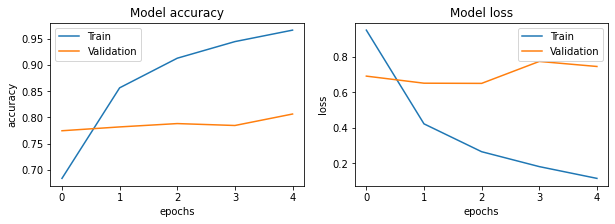

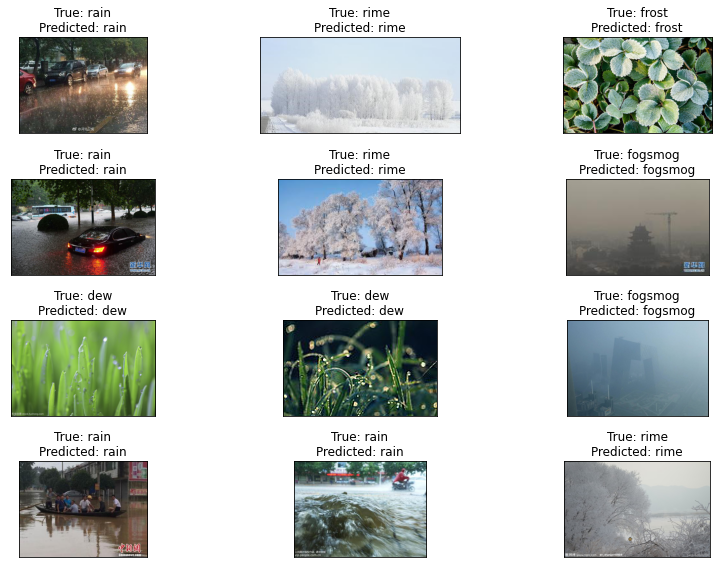

    Test Loss: 0.61260
Test Accuracy: 83.07%


In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

#  VGG19

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
80150528/80134624 [==============================] - 2s 0us/step
              precision    recall  f1-score   support

         dew       0.86      0.82      0.84       146
     fogsmog       0.84      0.83      0.83       173
       frost       0.54      0.60      0.57        93
       glaze       0.68      0.63      0.65       147
        hail       0.80      0.87      0.84       102
   lightning       0.87      0.95      0.91        73
        rain       0.80      0.73      0.76       107
     rainbow       0.91      0.93      0.92        44
        rime       0.85      0.82      0.84       245
   sandstorm       0.85      0.88      0.86       126
        snow       0.68      0.71      0.69       120

    accuracy                           0.79      1376
   macro avg       0.79      0.80      0.79  

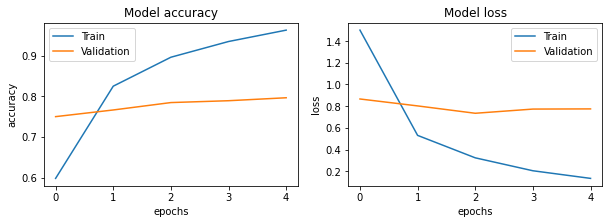

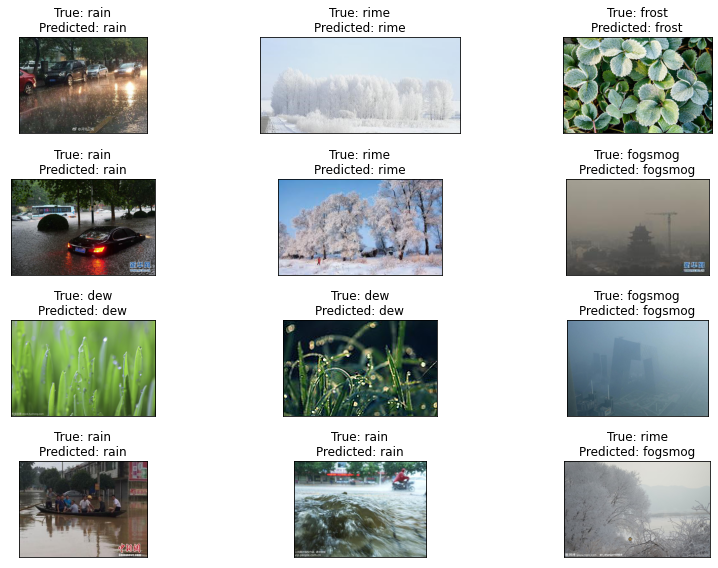

    Test Loss: 0.83680
Test Accuracy: 78.92%


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

#  Xception

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
83697664/83683744 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.91      0.83      0.87       146
     fogsmog       0.80      0.76      0.78       173
       frost       0.58      0.65      0.61        93
       glaze       0.65      0.64      0.64       147
        hail       0.75      0.89      0.81       102
   lightning       0.93      0.92      0.92        73
        rain       0.81      0.67      0.73       107
     rainbow       0.83      0.86      0.84        44
        rime       0.77      0.82      0.79       245
   sandstorm       0.77      0.83      0.80       126
        snow       0.64      0.57      0.61       120

    accuracy                           0.76      1376
   macro avg       0.77      0.77      0.77  

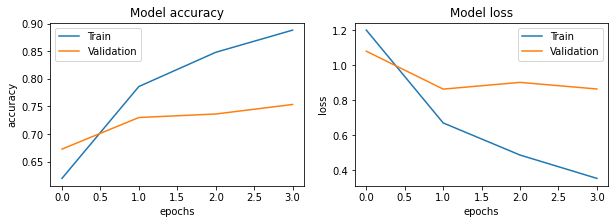

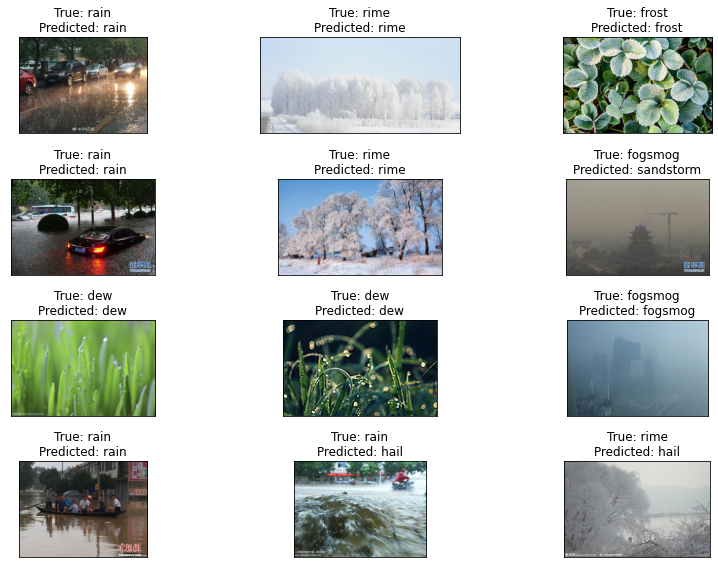

    Test Loss: 0.81368
Test Accuracy: 76.16%


In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

#  InceptionResNetV2

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
219070464/219055592 [==============================] - 2s 0us/step
              precision    recall  f1-score   support

         dew       0.85      0.73      0.79       146
     fogsmog       0.79      0.82      0.80       173
       frost       0.53      0.63      0.58        93
       glaze       0.66      0.54      0.60       147
        hail       0.75      0.80      0.77       102
   lightning       0.89      0.89      0.89        73
        rain       0.72      0.67      0.70       107
     rainbow       0.79      0.86      0.83        44
        rime       0.71      0.85      0.77       245
   sandstorm       0.72      0.76      0.74       126
        snow       0.73      0.49      0.59       120

    accuracy                           0.73      1376
   macro avg       0.74      0.73      0.73

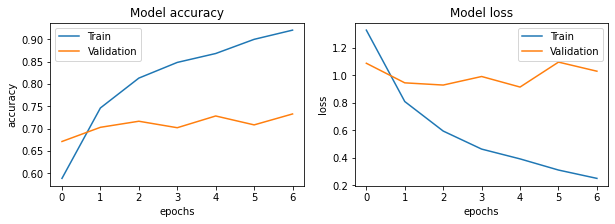

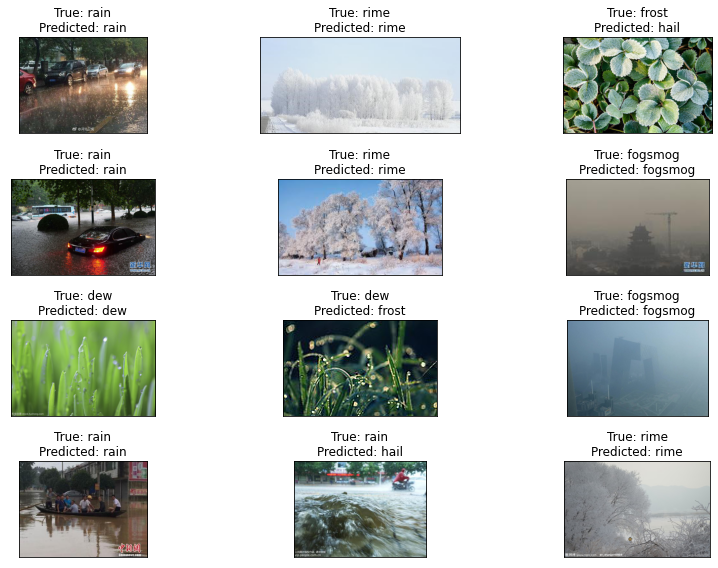

    Test Loss: 1.12444
Test Accuracy: 73.18%


In [16]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

#  VGG16

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
58900480/58889256 [==============================] - 0s 0us/step
              precision    recall  f1-score   support

         dew       0.95      0.78      0.86       146
     fogsmog       0.84      0.90      0.87       173
       frost       0.62      0.57      0.59        93
       glaze       0.63      0.73      0.68       147
        hail       0.76      0.88      0.82       102
   lightning       0.93      0.93      0.93        73
        rain       0.87      0.69      0.77       107
     rainbow       0.91      0.95      0.93        44
        rime       0.80      0.82      0.81       245
   sandstorm       0.85      0.83      0.84       126
        snow       0.68      0.66      0.67       120

    accuracy                           0.79      1376
   macro avg       0.80      0.80      0.80  

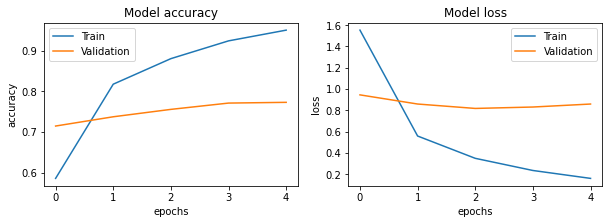

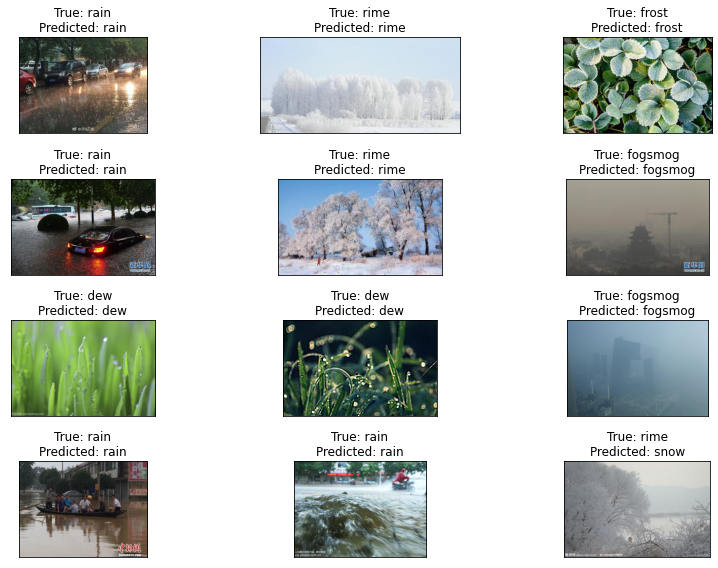

    Test Loss: 0.82328
Test Accuracy: 79.14%


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

# ResNet101

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
171458560/171446536 [==============================] - 4s 0us/step
              precision    recall  f1-score   support

         dew       0.95      0.89      0.92       146
     fogsmog       0.84      0.96      0.89       173
       frost       0.50      0.80      0.61        93
       glaze       0.66      0.65      0.66       147
        hail       0.96      0.85      0.90       102
   lightning       0.87      0.95      0.91        73
        rain       0.79      0.79      0.79       107
     rainbow       0.88      0.95      0.91        44
        rime       0.83      0.88      0.85       245
   sandstorm       0.97      0.80      0.88       126
        snow       0.92      0.46      0.61       120

    accuracy                           0.81      1376
   macro avg       0.83      0.82      0.81

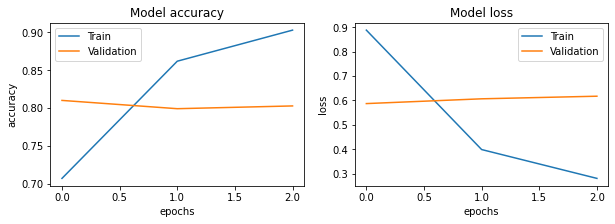

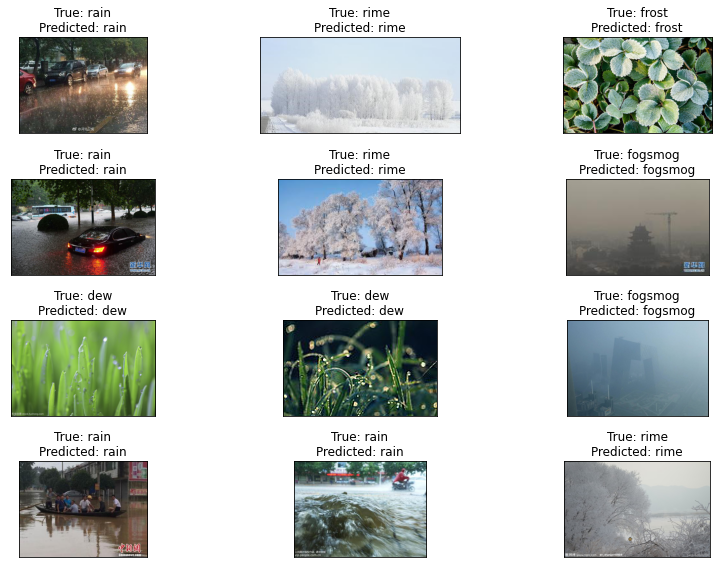

    Test Loss: 0.64591
Test Accuracy: 81.32%


In [18]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

#  DenseNet201

Found 4401 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
Found 1376 validated image filenames belonging to 11 classes.
74850304/74836368 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.94      0.90      0.92       146
     fogsmog       0.84      0.95      0.89       173
       frost       0.84      0.62      0.72        93
       glaze       0.70      0.78      0.74       147
        hail       0.84      0.94      0.89       102
   lightning       0.93      0.93      0.93        73
        rain       0.82      0.79      0.80       107
     rainbow       0.89      0.95      0.92        44
        rime       0.82      0.87      0.84       245
   sandstorm       0.93      0.87      0.90       126
        snow       0.79      0.63      0.70       120

    accuracy                           0.84      1376
   macro avg       0.85      0.84      0.84  

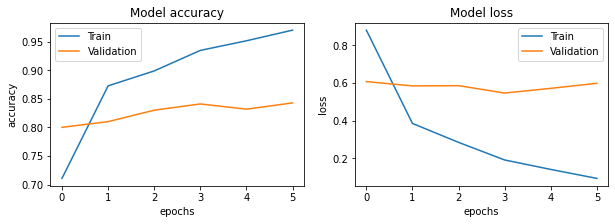

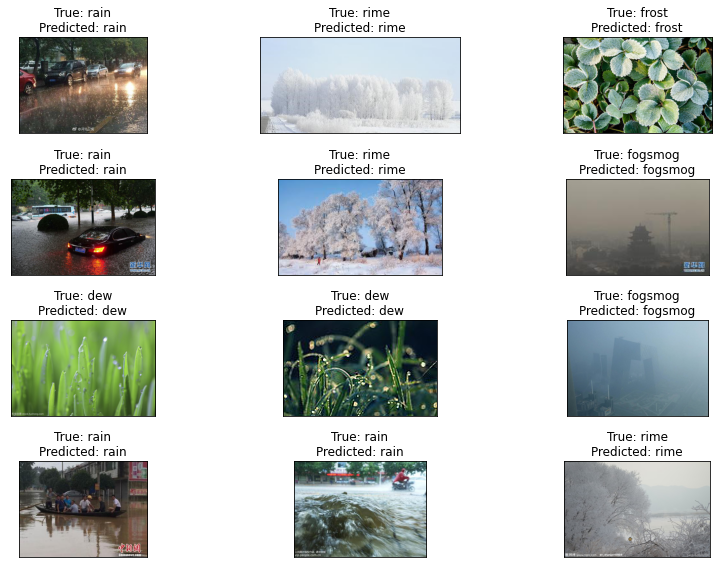

    Test Loss: 0.62897
Test Accuracy: 84.01%


In [19]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

#  Final Report

In [20]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101','DenseNet201'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1],
                                 result_DenseNet201[1]]})

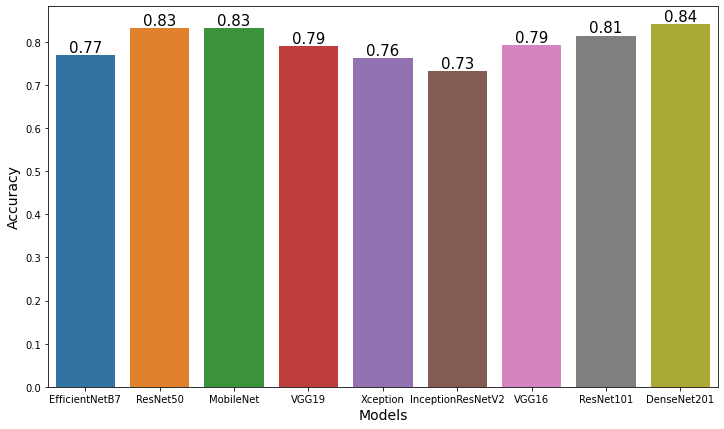

In [21]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()